In [1]:
import os, glob, time, datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, show_comparison

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

## 110epoch trained model import

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 128
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['110-0602-01:05-Encoder.pkl', '110-0602-01:05-Decoder.pkl', '110-0602-01:05-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

110 epoch trained model has restored


## Load Data

In [6]:
data_dir = './dataset/'
fixed_dir = './fixed_sample'

In [7]:
data_provider = TrainDataProvider(data_dir)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 74748 examples
unpickled total 151911 examples
train examples -> 74748, val examples -> 151911
total batches: 584


In [8]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

## Validation data with sharpening kernel

In [9]:
font_labels = list(range(25))
fake_targets = {i: [] for i in font_labels}
real_targets = {i: [] for i in font_labels}
sharpen_fake_targets = {i: [] for i in font_labels}

In [10]:
val_batch_iter = data_provider.get_val_iter(BATCH_SIZE)

for i, batch in enumerate(val_batch_iter):
    labels, batch_images = batch
    batch_images = batch_images.cuda()
    embedding_ids = labels
    
    # target / source images
    real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    
    # generate fake image
    fake_target, encoded_source = Generator(real_source, En, De, embeddings, embedding_ids, GPU=GPU)
    
    # sharpening with kernel
    import torch.nn.functional as F

    sharpen = torch.tensor([[0., -1., 0.],
                            [-1., 5., -1.],
                            [0., -1., 0.]]).cuda()
    sharpen = sharpen.view(1, 1, 3, 3)
    sharpen_fake_target = F.conv2d(fake_target, sharpen, padding=1)
    
    # save fake images by filtering with fonts
    for label, (real_target, fake, sharpen_fake) in zip(labels, zip(real_target, fake_target, sharpen_fake_target)):
        fake_targets[label].append(fake.cpu().detach().numpy())
        real_targets[label].append(real_target.cpu().detach().numpy())
        sharpen_fake = sharpen_fake.cpu().detach().numpy().clip(-1, 1)
        sharpen_fake_targets[label].append(sharpen_fake)
    
    if i == 20:
        break

## Sharpening experiment

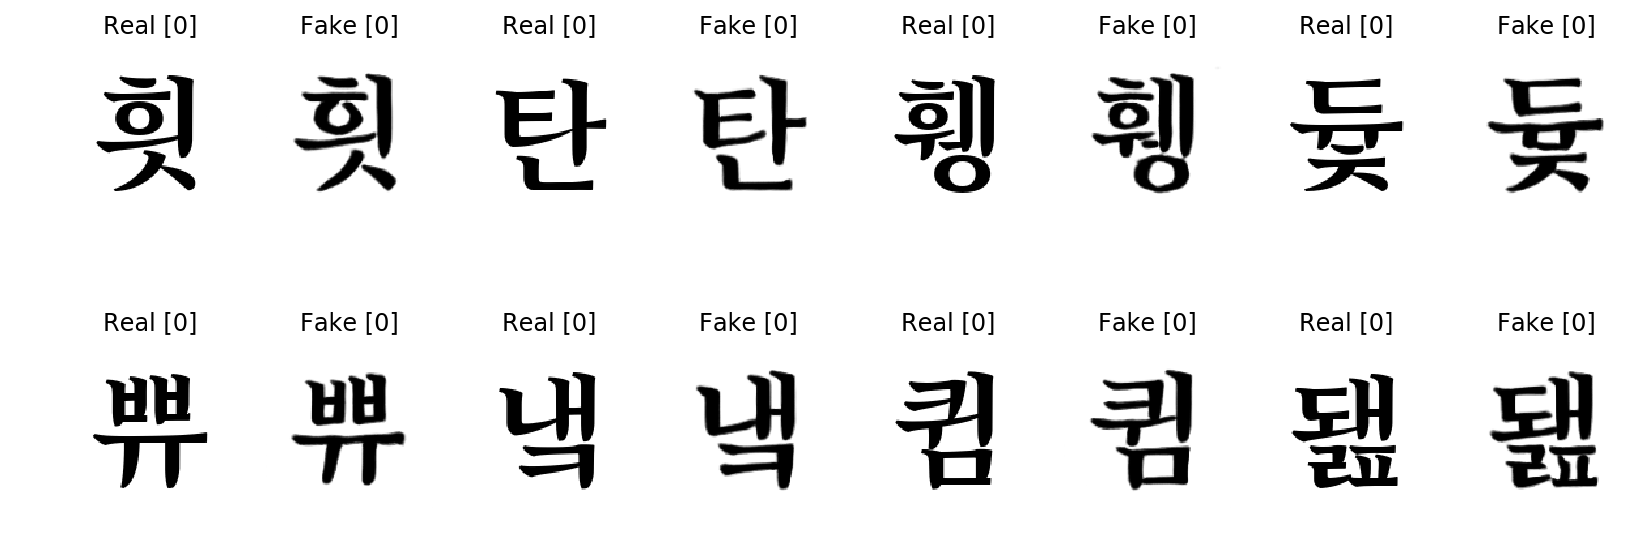

In [11]:
show_comparison(0, real_targets, fake_targets, show_num=8)

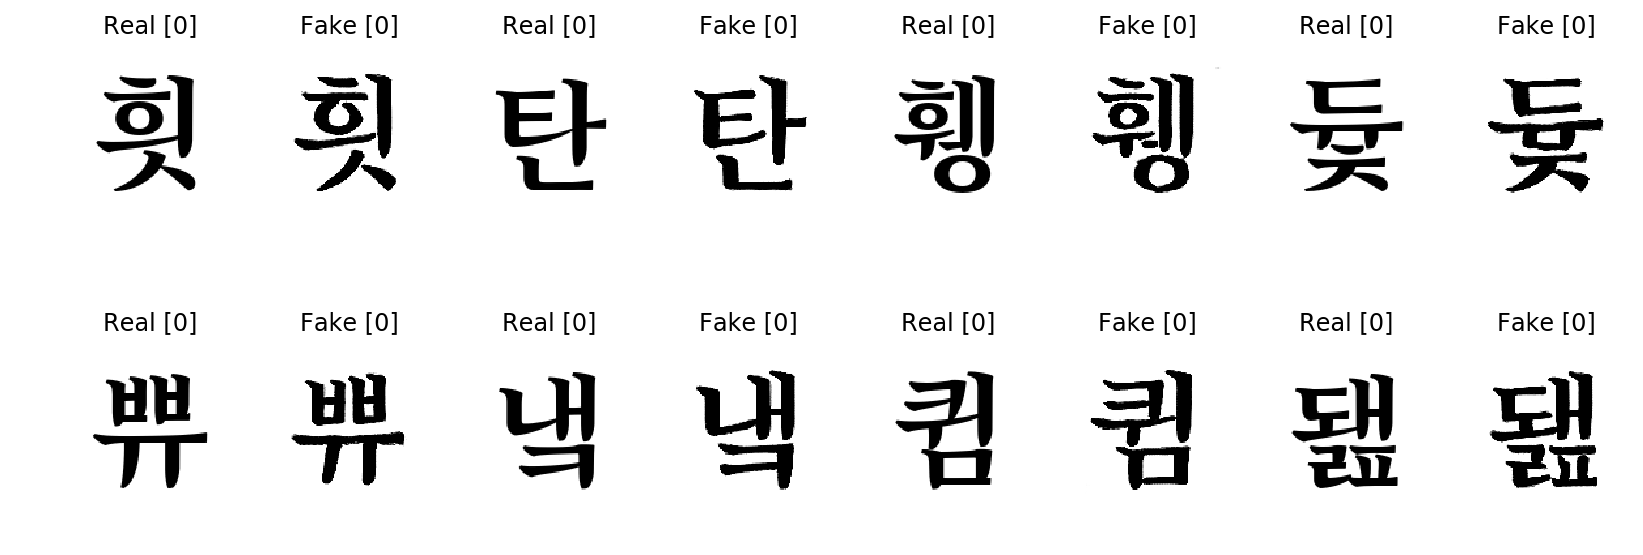

In [12]:
show_comparison(0, real_targets, sharpen_fake_targets, show_num=8)

- sharpen 되었긴 하지만 조금 울퉁불퉁해진 느낌

## validation data with round to -1 or 1

In [9]:
font_labels = list(range(25))
fake_targets = {i: [] for i in font_labels}
real_targets = {i: [] for i in font_labels}
sharpen_fake_targets = {i: [] for i in font_labels}

In [54]:
val_batch_iter = data_provider.get_val_iter(BATCH_SIZE)

for i, batch in enumerate(val_batch_iter):
    labels, batch_images = batch
    batch_images = batch_images.cuda()
    embedding_ids = labels
    
    # target / source images
    real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    
    # generate fake image
    fake_target, encoded_source = Generator(real_source, En, De, embeddings, embedding_ids, GPU=GPU)
    
    # save fake images by filtering with fonts
    for label, (real_target, fake) in zip(labels, zip(real_target, fake_target)):
        fake_targets[label].append(fake.cpu().detach().numpy())
        real_targets[label].append(real_target.cpu().detach().numpy())
        
        # sharpening with round
        round_function = lambda i: 1 if i > 0 else -1
        sharpen_fake = np.array(list(map(round_function, fake.cpu().detach().numpy().flatten())))
        sharpen_fake_targets[label].append(sharpen_fake.reshape(1, 1, 128, 128))
    
    if i == 1:
        break

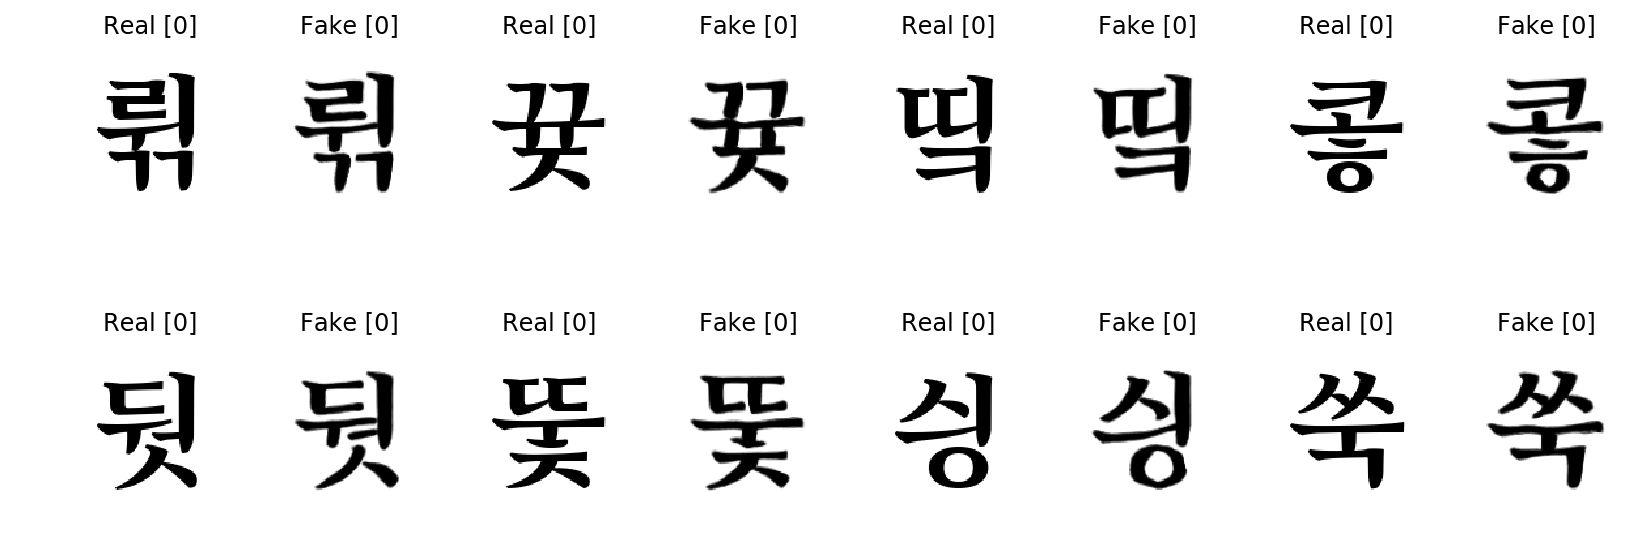

In [56]:
show_comparison(0, real_targets, fake_targets, show_num=8)

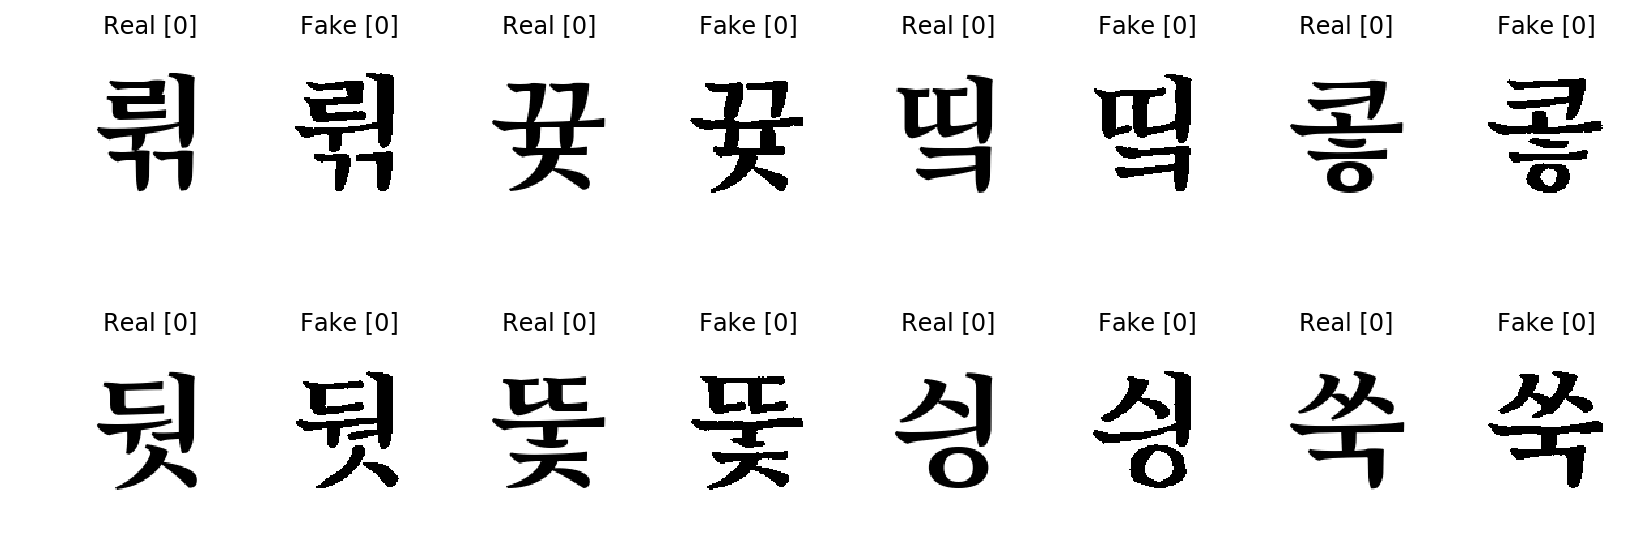

In [55]:
show_comparison(0, real_targets, sharpen_fake_targets, show_num=8)

- 역시 울퉁불퉁함

## Sharpening with Median Filter

In [61]:
font_labels = list(range(25))
fake_targets = {i: [] for i in font_labels}
real_targets = {i: [] for i in font_labels}
sharpen_fake_targets = {i: [] for i in font_labels}

In [57]:
from scipy.signal import medfilt2d

In [62]:
val_batch_iter = data_provider.get_val_iter(BATCH_SIZE)

for i, batch in enumerate(val_batch_iter):
    labels, batch_images = batch
    batch_images = batch_images.cuda()
    embedding_ids = labels
    
    # target / source images
    real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    
    # generate fake image
    fake_target, encoded_source = Generator(real_source, En, De, embeddings, embedding_ids, GPU=GPU)
    
    # save fake images by filtering with fonts
    for label, (real_target, fake) in zip(labels, zip(real_target, fake_target)):
        fake_targets[label].append(fake.cpu().detach().numpy())
        real_targets[label].append(real_target.cpu().detach().numpy())
        
        # sharpening with round
        sharpen_fake = medfilt2d(fake.cpu().detach().numpy().reshape(128, 128))
        sharpen_fake_targets[label].append(sharpen_fake.reshape(1, 1, 128, 128))
    
    if i == 1:
        break

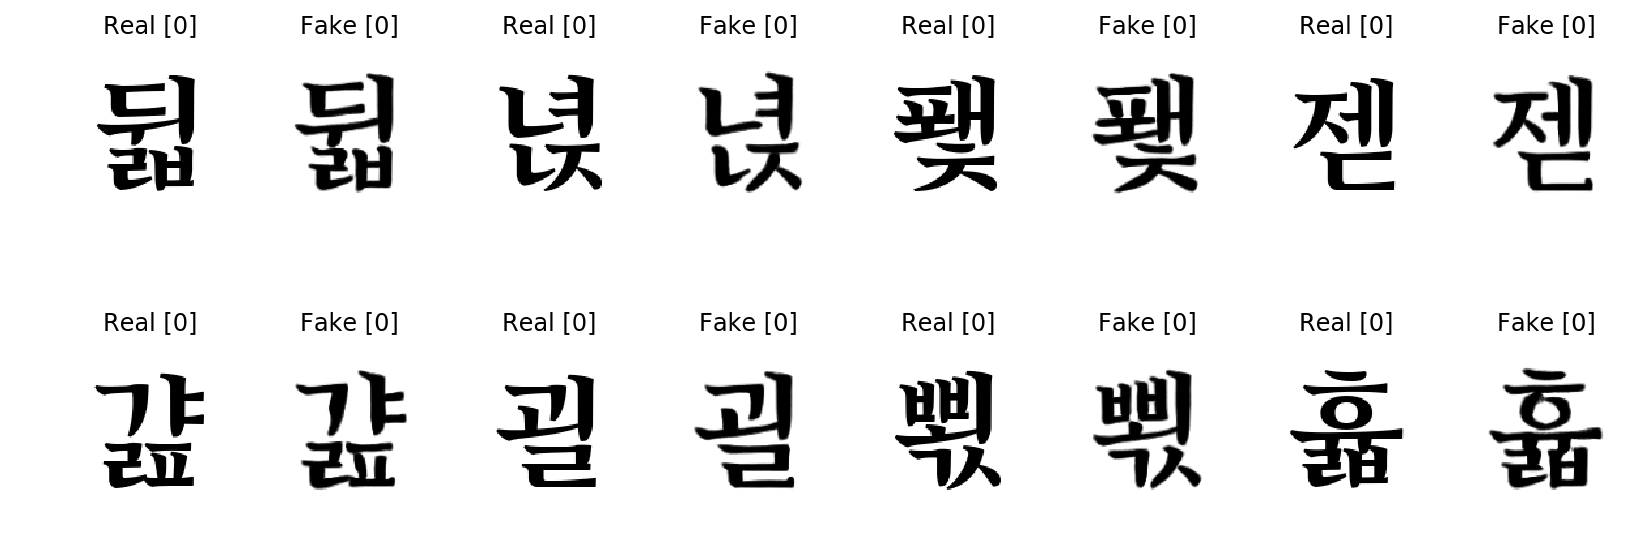

In [63]:
show_comparison(0, real_targets, fake_targets, show_num=8)

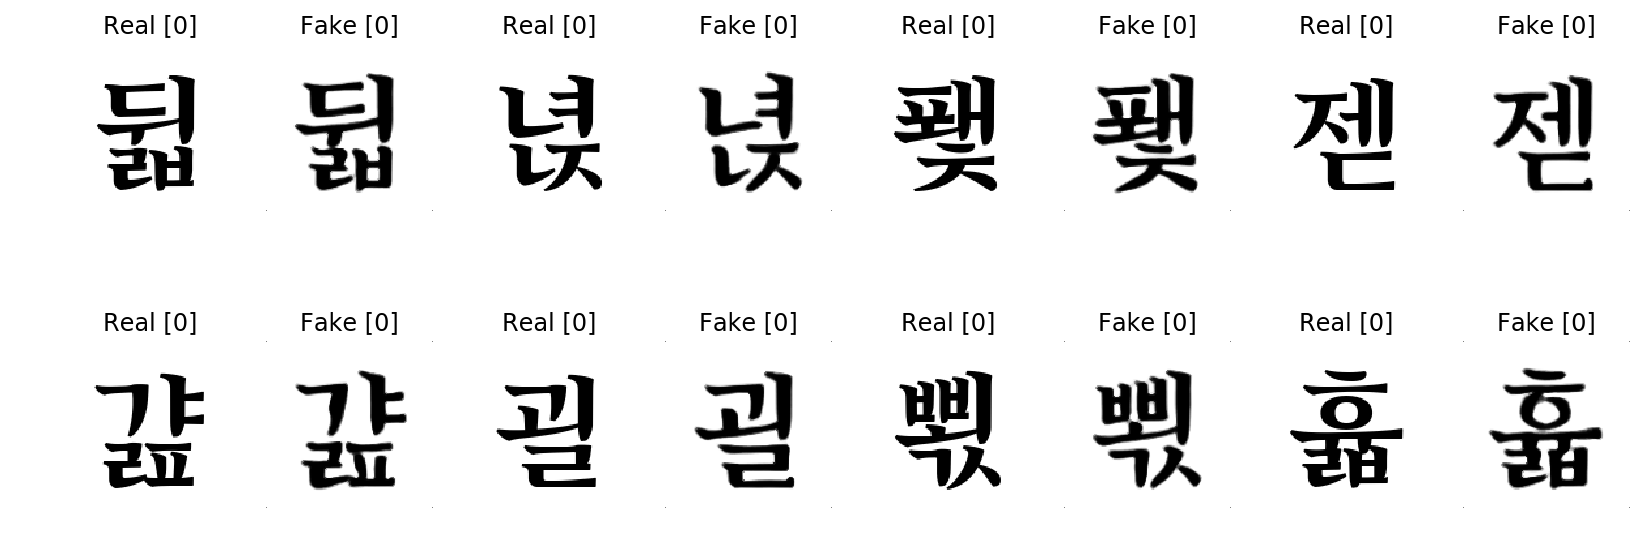

In [64]:
show_comparison(0, real_targets, sharpen_fake_targets, show_num=8)

- 별 차이 없음